# Conspiracy Theory Analysis on Truth Social

## Imports and DB Connection

In [80]:
import mysql.connector
from sqlalchemy import create_engine
import pymysql

import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
from networkx.algorithms.community import girvan_newman

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from collections import Counter
import string
import re

from wordcloud import WordCloud

from gensim import corpora
from gensim.models import LdaModel

In [86]:
plt.rcParams.update({'font.size': 12})

In [3]:
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')

In [4]:
STOP_WORDS = set(stopwords.words('english')) 

In [5]:
psw = ''

conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root', 
    password = psw,
    database = 'truth_social')

cursor = conn.cursor()

## Util

In [6]:
def clean_text(text):
    text = re.sub(r'<emoji:\s\w+>', '', text) # Remove emoji
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions (@Maria)
    text = re.sub(r'https?\/\/S+', '',  text) # remove the hyperlink
    text = re.sub(r'http\S+', '',  text)      # remove the hyperlink
    text = re.sub(r'www\S+', '',  text)       # remove the www
    text = re.sub(r'[^\w\s]', '', text)       # Remove punct
    
    return text

In [7]:
cursor.execute("SELECT * FROM truths")
headers = [column[0] for column in cursor.description]
truths = pd.DataFrame(cursor.fetchall(), columns=headers)
truths.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id
0,18,2022-09-11 20:24:00,2022-09-14 17:27:43,0,0,26,12300,2760,590,"On this day, let’s also never forget those who...",https://truthsocial.com/@EricTrump/posts/10898...,-1,108982585515785274
1,21,2022-07-30 19:05:00,2022-09-14 20:54:37,0,0,26,5660,789,346,#LIVGolf is off the charts! @TrumpBedminster,https://truthsocial.com/@EricTrump/posts/10873...,-1,108738795367938727
2,26,2022-06-22 09:47:00,2022-09-14 22:11:40,1,0,26,0,0,0,The deal on “Gun Control” currently being stru...,https://truthsocial.com/@EricTrump/posts/10852...,2420,108527713196735892
3,29,2022-08-19 18:24:00,2022-09-14 22:30:01,0,0,26,15700,3320,1110,<emoji: us><emoji: us><emoji: us>,https://truthsocial.com/@EricTrump/posts/10885...,-1,108851881295512464
4,34,2022-05-13 13:58:00,2022-09-14 22:57:18,0,1,26,2640,401,67,See you soon!!!,https://truthsocial.com/@EricTrump/posts/10829...,-1,108295925937467612


In [8]:
truths.dropna(subset=['text'], inplace=True)

In [9]:
#truths['text'] = truths['text'].apply(clean_text)
#truths['text']

## Analyzing Conspiracy related posts

### Flat Earth

* Lots of posts are in favor of the flat earth theory, generally based on religious reasons.
* There are also posts criticizing and/or arguing against it.

In [10]:
flat_earth = truths[truths['text'].str.contains(r'\bflat earth\b', case=False)]


for index, row in flat_earth.sample(n=10).iterrows():
    print(row['text'])
    print(f"Likes: {row['like_count']}  Replies: {row['reply_count']}  Retruths: {row['retruth_count']}")
    print('\n')

Just curious, Shaun, you know I love ya, so this is in no way a personal question, but why isn’t flat earth possible?
Likes: 1  Replies: 1  Retruths: 0


Not discrediting you. Just asking how you believe this idea. Based on what? Like I said not to start anything. I really don’t think anything about the concept of flat earth other than it’s NOT the truth. Just sayin. Peace to you fren.
Likes: 7  Replies: 3  Retruths: 1


This is true, but you see how well a Flat Earth goes over here on Truth Social…we might as well be dinosaurs! <emoji: joy>
Likes: 2  Replies: 2  Retruths: 3


I remember being so snarky against Flat Earthers, then decided to take the challenge and watched the vids posted, which was this series.  My goal was to come back and point out how utterly crazy you all were, only I was the one who got schooled, and humbled.  I believe if more people would challenge themselves to watch the videos, there would be a lot less snarkiness in this confusing world.  So I encourage every

### QAnon

QAnon is a wide-ranging conspiracy theory that says that President Trump is waging a secret war against elite Satan-worshipping paedophiles in government, business and the media. 

* Lots of posts use the hashtags ```#MAGA``` wich means "Make America great again" and ```#WWG1WGA``` ("Where We Go One, We Go All")
* Other QAnon related phrases are “The Storm“, “The Calm Before the Storm” and “Qanon8chan“. The acronyms MAGA and KAG – the acronyms of the Trump 2016 and 2020 campaigns – are often frequently alongside since most social media users posting in support of QAnon are also supporters of President Trump.


In [11]:
qanon = truths[truths['text'].str.contains(r'\bqanon\b', case=False)]

for index, row in qanon.sample(n=10).iterrows():
    print(row['text'])
    print(f"Likes: {row['like_count']}  Replies: {row['reply_count']}  Retruths: {row['retruth_count']}")
    print('\n')

Break in’ the law, breakin’ the law<emoji: sunglasses> #truth #trump #biden #ukraine #russia #q #ncswic #qanon #thegreatawakening #faith #gasprices #covid
Likes: 90  Replies: 1  Retruths: 22


“trip 5's confirm those who oppose humanity have no nation.”  From: https://t.me/NEWSthatBITES  #q #patriots #qanon #trump #maga #truth
Likes: 1  Replies: 0  Retruths: 0


Get ‘Em Donald….let’s drain that swamp FOREVER  <emoji: boom> <emoji: boom><emoji: boom><emoji: boom> <emoji: dash>  @realDonaldTrump   #TrumpWon #TrumpWasRight #Trumpwon2020 #Q #Qanon #WWG1WGA #BoomWeek #boom #forgodandcountry #GodWins #DraintheSwamp #LockThemUp
Likes: 3  Replies: 0  Retruths: 0


If you only knew how bad things really are..  #trump #q #qanon #memes #maga #wwg1wga #thesepeoplearesick
Likes: 0  Replies: 0  Retruths: 0


Heard about the Con Heiress Anna Delvey? Isn’t it interesting that criminals always come for @realDonaldTrump ? <emoji: joy><emoji: joy><emoji: skull> https://www.insider.com/anna-sorokin-delvey

## External Links Analysis

In [12]:
def extract_links(text):
    urls = re.findall(r'(https?://\S+|www\.\S+)', text)
    return urls

def extract_domain(link):
    match = re.search(r"(https?://)?(www\d?\.)?(?P<domain>[\w.-]+)", link)
    
    if match:
        return match.group("domain")
    
    return None

In [13]:
# Extract links from posts into new column and explode
truths['links'] = truths['text'].apply(extract_links)

In [14]:
truths_with_links = truths.explode('links')
truths_with_links.dropna(subset=['links'], inplace=True)
truths_with_links.shape

(204543, 14)

In [15]:
# Extract links domain
domain_search_regexp = 'https?://([A-Za-z_0-9.-]+).*|www\.([A-Za-z_0-9.-]+).*'
#truths_with_links['domain'] = truths_with_links['links'].apply(lambda x: re.search(domain_search_regexp, x).group(1) 
                                 #if re.search(domain_search_regexp, x) else None)

truths_with_links['domain'] = truths_with_links['links'].apply(extract_domain)

In [16]:
truths_with_links.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id,links,domain
9,41,2022-08-29 21:30:00,2022-09-14 23:15:18,0,0,26,7930,2500,1010,https://nypost.com/2022/08/29/fbi-agent-resign...,https://truthsocial.com/@EricTrump/posts/10890...,-1,108909234033014750,https://nypost.com/2022/08/29/fbi-agent-resign...,nypost.com
46,78,2022-05-22 19:23:00,2022-09-15 01:51:50,0,0,26,9020,1830,518,One of the most beautiful places on earth! Com...,https://truthsocial.com/@EricTrump/posts/10834...,26,108348166778636199,www.TrumpWinery.com,TrumpWinery.com
47,79,2022-05-12 16:30:00,2022-09-15 01:51:51,1,0,26,3620,832,137,We look forward to hosting you at the all-new ...,https://truthsocial.com/@EricTrump/posts/10834...,26,108340573840919538,www.LIVGolf.com.,LIVGolf.com.
51,83,2022-05-19 16:27:00,2022-09-15 01:56:31,0,0,26,9310,2920,315,Amazing book by Kash Patel!￼ https://brave-bo...,https://truthsocial.com/@EricTrump/posts/10833...,26,108330487343291459,https://brave-books-series.myshopify.com/produ...,brave-books-series.myshopify.com
63,95,2022-05-03 22:04:00,2022-09-15 01:56:41,0,0,26,10400,1890,291,Cheers to a big night in Ohio! <emoji: us><emo...,https://truthsocial.com/@EricTrump/posts/10824...,26,108241214755116853,www.TrumpWinery.com,TrumpWinery.com


In [17]:
print(f"Unique links: {truths_with_links['links'].nunique()}")

Unique links: 129716


In [18]:
domain_count = truths_with_links['domain'].value_counts()
print(f"Unique domains: {domain_count.shape[0]}")

Unique domains: 5075


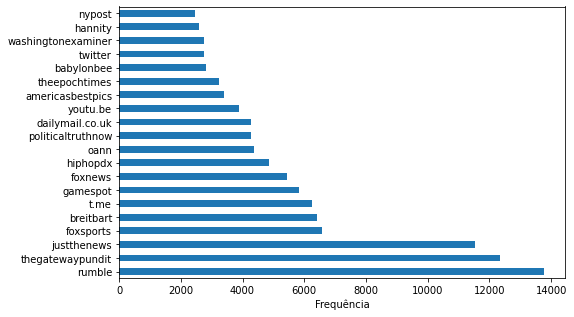

In [19]:
domain_count.index = domain_count.index.str.replace(r'\.com$', '', regex=True)

plt.figure(figsize=(8, 5))
domain_count.head(20).plot(kind='barh')
plt.xlabel('Frequência')
plt.show()

Content on site **thegatewaypundit**.

The Gateway Pundit (TGP) is an American far-right fake news website. The website is known for publishing falsehoods, hoaxes, and conspiracy theories. (Wikipedia)

In [20]:
# Considering unique posts with "thegatewaypundit.com" domain
gatewaypundit = truths_with_links.loc[truths_with_links['domain'] == 'thegatewaypundit.com']
gatewaypundit = gatewaypundit.drop_duplicates(subset=['id'], keep='first')
gatewaypundit.shape

(12316, 15)

In [21]:
gatewaypundit.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id,links,domain
1281,1598,2022-09-12 13:37:00,2022-09-15 22:37:16,1,0,27,0,0,0,https://www.thegatewaypundit.com/2022/09/trump...,https://truthsocial.com/@realDonaldTrump/posts...,1598,108987518354043181,https://www.thegatewaypundit.com/2022/09/trump...,thegatewaypundit.com
1292,1610,2022-09-12 11:13:00,2022-09-15 22:37:35,0,0,27,10000,3130,184,https://www.thegatewaypundit.com/2022/09/watch...,https://truthsocial.com/@realDonaldTrump/posts...,-1,108986080451280854,https://www.thegatewaypundit.com/2022/09/watch...,thegatewaypundit.com
1331,1651,2022-09-06 12:07:00,2022-09-15 22:38:13,0,0,27,20300,5610,411,“EXCLUSIVE: Arizona Republicans CENSURE Rogue ...,https://truthsocial.com/@realDonaldTrump/posts...,-1,108952320526895951,https://www.thegatewaypundit.com/2022/08/exclu...,thegatewaypundit.com
1775,2144,2022-07-25 15:37:00,2022-09-15 22:47:01,0,0,27,13600,5050,552,https://www.thegatewaypundit.com/2022/07/trump...,https://truthsocial.com/@realDonaldTrump/posts...,-1,108709665031742543,https://www.thegatewaypundit.com/2022/07/trump...,thegatewaypundit.com
1789,2161,2022-07-22 21:31:00,2022-09-15 22:47:22,0,0,27,14300,4200,365,https://www.thegatewaypundit.com/2022/07/break...,https://truthsocial.com/@realDonaldTrump/posts...,-1,108694071615523649,https://www.thegatewaypundit.com/2022/07/break...,thegatewaypundit.com


In [22]:
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<emoji:\s\w+>', '', text) # Remove emoji
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # Remove mentions (@Maria)
    text = re.sub(r'https?://.+?\.com', '', text) # Remove domain/
    text = re.sub(r'[^a-zA-Z]', ' ', text) # Remove punct
    
    return text


def tokenize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in STOP_WORDS]

    return tokens

In [23]:
tokenized_text = gatewaypundit['text'].apply(clean_text)
tokenized_text = tokenized_text.apply(tokenize_text)
tokenized_text

1281      [trump, towering, political, figure, living, m...
1292      [watch, tide, overpower, deep, state, sandcast...
1331      [exclusive, arizona, republican, censure, rogu...
1775      [trump, right, china, placed, huawei, equipmen...
1789      [breaking, big, wisconsin, state, senator, jan...
                                ...                        
837471    [definitely, make, putin, double, shocking, vi...
837480    [calling, patriot, urgent, development, donald...
837720    [update, organizer, usa, trucker, convoy, rele...
837749    [stand, finchem, exclusive, arizona, senate, p...
837955    [time, stand, growing, tyranny, right, time, s...
Name: text, Length: 12316, dtype: object

In [24]:
dictionary = corpora.Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(tokens) for tokens in tokenized_text]

# Train LDA model
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print Topics
topics = lda_model.print_topics(num_words=7)
for topic in topics:
    print(topic)

(0, '0.021*"biden" + 0.017*"governor" + 0.013*"video" + 0.011*"new" + 0.010*"cheating" + 0.009*"dixon" + 0.009*"tudor"')
(1, '0.029*"campaign" + 0.026*"source" + 0.023*"utm" + 0.019*"trump" + 0.018*"medium" + 0.018*"biden" + 0.016*"u"')
(2, '0.050*"election" + 0.023*"county" + 0.017*"state" + 0.015*"breaking" + 0.014*"vote" + 0.013*"primary" + 0.013*"gop"')
(3, '0.025*"video" + 0.014*"white" + 0.013*"house" + 0.011*"biden" + 0.010*"police" + 0.010*"joe" + 0.009*"trump"')
(4, '0.014*"ballot" + 0.011*"day" + 0.010*"u" + 0.009*"one" + 0.008*"trafficking" + 0.008*"election" + 0.008*"arizona"')
(5, '0.027*"covid" + 0.023*"vaccine" + 0.012*"video" + 0.010*"drop" + 0.009*"year" + 0.009*"old" + 0.007*"death"')
(6, '0.042*"fbi" + 0.016*"exclusive" + 0.014*"trump" + 0.013*"jan" + 0.013*"investigation" + 0.013*"steve" + 0.013*"bannon"')
(7, '0.017*"biden" + 0.015*"video" + 0.014*"trump" + 0.009*"hillary" + 0.008*"russia" + 0.008*"mich" + 0.007*"joe"')
(8, '0.024*"trump" + 0.022*"biden" + 0.014*"p

## Conspiracy Content Analysis

**QAnon**

In [25]:
res = truths[truths['text'].str.contains(r'qanon', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:513
Number of reactions (likes, retruths and replies): 35344


**\#WWG1WGA**

In [26]:
res = truths[truths['text'].str.contains(r'#WWG1WGA', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:1580
Number of reactions (likes, retruths and replies): 73271


**\#thegreatawakening**

In [27]:
res = truths[truths['text'].str.contains(r'#thegreatawakening', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:175
Number of reactions (likes, retruths and replies): 16028


**deep state**

In [28]:
res = truths[truths['text'].str.contains(r'deep state', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:1824
Number of reactions (likes, retruths and replies): 263969


**election fraud**

In [29]:
res = truths[truths['text'].str.contains(r'(?:election.*fraud|fraud.*election)', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:4496
Number of reactions (likes, retruths and replies): 3619905


**climate change**

In [30]:
res = truths[truths['text'].str.contains(r'(?:climate.*fake|fake.*climate)', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:35
Number of reactions (likes, retruths and replies): 5762


In [31]:
res = truths[truths['text'].str.contains(r'(?:climate.*lie|lie.*climate)', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:142
Number of reactions (likes, retruths and replies): 29457


In [32]:
res = truths[truths['text'].str.contains(r'(?:climate.*hoax|hoax.*climate)', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:187
Number of reactions (likes, retruths and replies): 40371


In [33]:
res = truths[truths['text'].str.contains(r'climate change', case=False)]
print(f"Number of posts:{res.shape[0]}")
reactions = res['like_count'].sum() + res['retruth_count'].sum() + res['reply_count'].sum()
print(f"Number of reactions (likes, retruths and replies): {reactions}")

Number of posts:776
Number of reactions (likes, retruths and replies): 223873


### Detecting conspiracy

In [34]:
cursor.execute("SELECT * FROM users")
headers = [column[0] for column in cursor.description]
users = pd.DataFrame(cursor.fetchall(), columns=headers)
users.head()

,id,timestamp,time_scraped,username,follower_count,following_count,profile_url,finished_follower_scrape,finished_following_scrape,finished_truth_scrape
0,22,2022-05-01,2022-09-04 23:14:03,ProjectVeritasAction,455386.0,2.0,https://truthsocial.com/@ProjectVeritasAction,1.0,1.0,1.0
1,23,2022-05-01,2022-09-04 23:32:45,ProjectVeritas,617923.0,15.0,https://truthsocial.com/@ProjectVeritas,1.0,1.0,1.0
2,24,2022-05-01,2022-09-04 23:32:57,JamesOKeefeIII,395827.0,5.0,https://truthsocial.com/@JamesOKeefeIII,1.0,1.0,1.0
3,25,2022-02-01,2022-09-04 23:34:48,JCSullivan,6942.0,221.0,https://truthsocial.com/@JCSullivan,0.0,0.0,0.0
4,26,2022-02-01,2022-09-04 23:48:56,EricTrump,1727967.0,178.0,https://truthsocial.com/@EricTrump,1.0,1.0,0.0


In [35]:
def has_conspiracy(post):
    regex = r'(qanon|#WWG1WGA|(?:election.*fraud|fraud.*election)|#thegreatawakening|deep state)'
    return bool(re.search(regex, post, flags=re.IGNORECASE))

def has_qanon_conspiracy(post):
    regex = r'(qanon|#WWG1WGA|#thegreatawakening|deep state)'
    return bool(re.search(regex, post, flags=re.IGNORECASE))

def has_election_conspiracy(post):
    regex = r'(?:election.*fraud|fraud.*election)'
    return bool(re.search(regex, post, flags=re.IGNORECASE))

def has_climate_conspiracy(post):
    regex = r'(?:climate.*fake|fake.*climate)|(?:climate.*lie|lie.*climate)|(?:climate.*hoax|hoax.*climate)|climate change'
    return bool(re.search(regex, post, flags=re.IGNORECASE))


truths['qanon'] = truths['text'].apply(has_qanon_conspiracy)
truths['election'] = truths['text'].apply(has_election_conspiracy)
truths['climate'] = truths['text'].apply(has_climate_conspiracy)

In [36]:
truths.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id,links,qanon,election,climate
0,18,2022-09-11 20:24:00,2022-09-14 17:27:43,0,0,26,12300,2760,590,"On this day, let’s also never forget those who...",https://truthsocial.com/@EricTrump/posts/10898...,-1,108982585515785274,[],False,False,False
1,21,2022-07-30 19:05:00,2022-09-14 20:54:37,0,0,26,5660,789,346,#LIVGolf is off the charts! @TrumpBedminster,https://truthsocial.com/@EricTrump/posts/10873...,-1,108738795367938727,[],False,False,False
2,26,2022-06-22 09:47:00,2022-09-14 22:11:40,1,0,26,0,0,0,The deal on “Gun Control” currently being stru...,https://truthsocial.com/@EricTrump/posts/10852...,2420,108527713196735892,[],False,False,False
3,29,2022-08-19 18:24:00,2022-09-14 22:30:01,0,0,26,15700,3320,1110,<emoji: us><emoji: us><emoji: us>,https://truthsocial.com/@EricTrump/posts/10885...,-1,108851881295512464,[],False,False,False
4,34,2022-05-13 13:58:00,2022-09-14 22:57:18,0,1,26,2640,401,67,See you soon!!!,https://truthsocial.com/@EricTrump/posts/10829...,-1,108295925937467612,[],False,False,False


In [37]:
truths[truths['qanon'] == True].shape

(3903, 17)

In [38]:
truths[truths['election'] == True].shape

(4496, 17)

In [39]:
truths[truths['climate'] == True].shape

(949, 17)

In [40]:
qanon_posts = truths[truths['qanon'] == True].copy()
election_posts = truths[truths['election'] == True].copy()
climate_posts = truths[truths['climate'] == True].copy()

qanon_posts['day'] = qanon_posts['timestamp'].dt.date
election_posts['day'] = election_posts['timestamp'].dt.date
climate_posts['day'] = climate_posts['timestamp'].dt.date

qanon_posts_per_day = qanon_posts['day'].value_counts().sort_index()
election_posts_per_day = election_posts['day'].value_counts().sort_index()
climate_posts_per_day = climate_posts['day'].value_counts().sort_index()

**Visualizing Conspiracy posts per day**

In [41]:
max_freq = max(qanon_posts_per_day.max(), election_posts_per_day.max(), climate_posts_per_day.max())

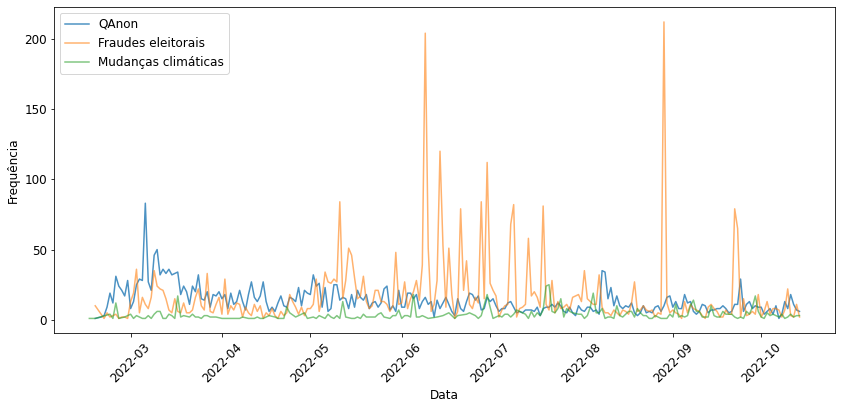

In [48]:
plt.figure(figsize=(14, 6))

(qanon_posts_per_day).plot(label='QAnon', alpha=0.8)
(election_posts_per_day).plot(label='Fraudes eleitorais', alpha=0.6)
(climate_posts_per_day).plot(label='Mudanças climáticas', alpha=0.6)

plt.ylabel('Frequência')
plt.xlabel('Data')
plt.legend()
plt.xticks(rotation=45)

plt.show()

**Analysing peak days**

In [49]:
def get_peaks_wordclouds(peak_days, conspiracy_posts):
    for day in peak_days:
        text = conspiracy_posts[conspiracy_posts['day'] == day]['text'].str.lower()
        text = text.apply(clean_text)
        text = text.apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in STOP_WORDS]))

        concat_text = ' '.join(text)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(concat_text)

        plt.figure(figsize=(10, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'WordCloud posts on peak day {day}')
        plt.axis('off')  # Remover os eixos
        plt.show()

QANON PEAK DAYS

* Peak of 2022-06-03 is a spam of one message of a [fake news](https://publichealthcollaborative.org/misinformation-alert/viral-posts-falsely-claim-pfizer-vaccine-killed-over-1200-during-vaccine-rollout/):

"They tried to ￼ ASSASSINATE you and your family.￼ All animals in clinical trial die. They killed over 1200 people in the clinical trials. 1291 known side effects. Then they tried to make it worldwide mandatory. Then they took away your rights if you didn’t get it. They try to bribe you to get it. Then tried to shame you to get it. Two years, every commercial, news broadcast, sports Hollywood music etc. ￼They did all of that attempting to ASSASSINATE you. Let it sink in what they did. #wwg1wga"

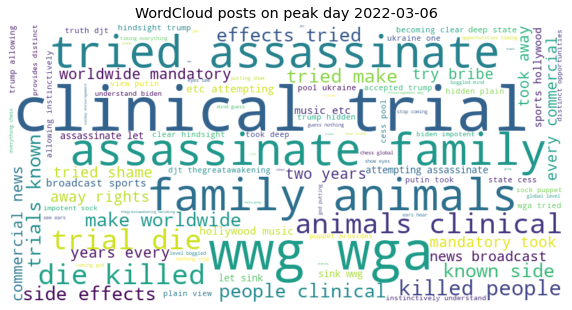

In [50]:
n_peaks = 1
peak_days = qanon_posts_per_day.sort_values(ascending=False).index[:n_peaks]
get_peaks_wordclouds(peak_days, qanon_posts)

ELECTION FRAUD PEAK DAYS

* Peak of 2022-08-09 is a spam of a [Donald Trump's post](https://truthsocial.com/@realDonaldTrump/posts/108906909057160138):

So now it comes out, conclusively, that the FBI BURIED THE HUNTER BIDEN LAPTOP STORY BEFORE THE ELECTION knowing that, if they didn’t, “Trump would have easily won the 2020 Presidential Election.” This is massive FRAUD and ELECTION INTERFERENCE at a  level never seen before in our Country. REMEDY: Declare the rightful winner or, and this would be the minimal solution, declare the 2020 Election irreparably compromised and have a new Election, immediately!

* Peak of 2022-06-09 is a spam of another [Donald Trump's post](https://truthsocial.com/@realDonaldTrump/posts/108450799748338217):

So the Unselect Committee of political HACKS refuses to play any of the many positive witnesses and statements, refuses to talk of the Election Fraud and Irregularities that took place on a massive scale, and decided to use a documentary maker from Fake News ABC to spin only negative footage. Our Country is in such trouble!

* Peak of 2022-06-30 is spam of [Trump's post](https://truthsocial.com/@realDonaldTrump/posts/108567396952771187):

Everyone must remember, this is all about massive Election Fraud which took place and which the Unselect Committee refuses to discuss. Likewise, they refuse to discuss the 10-20,000 soldiers that I offered 4 days earlier to secure the Capitol. Pelosi and the Mayor of DC, who are in charge of security, turned it down.

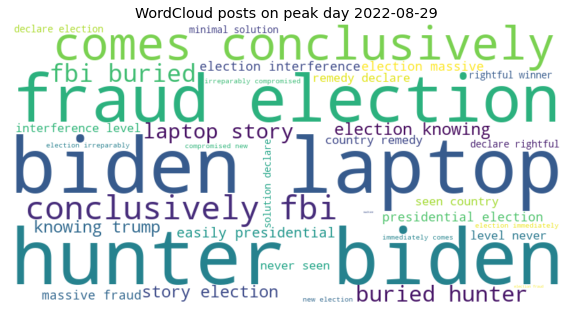

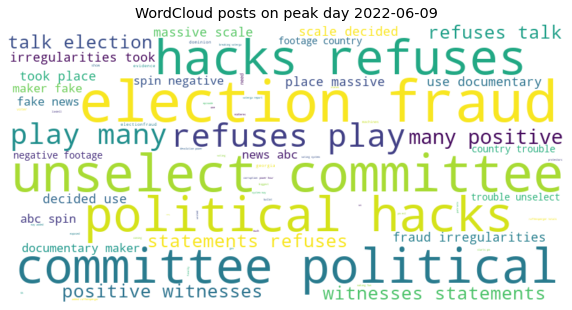

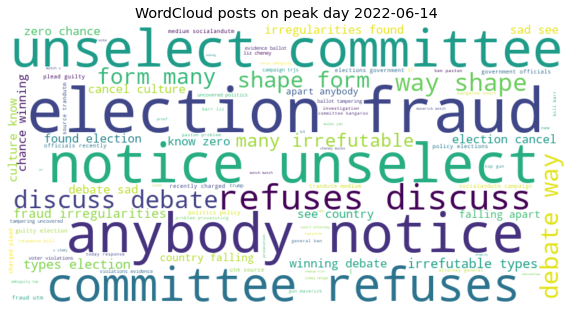

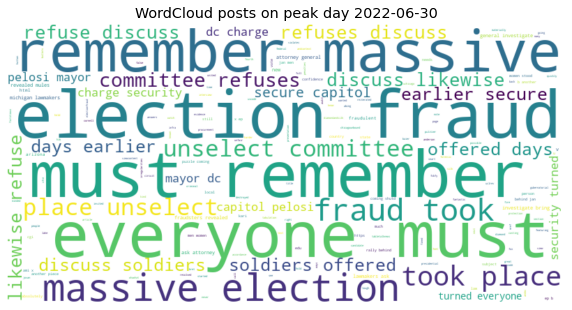

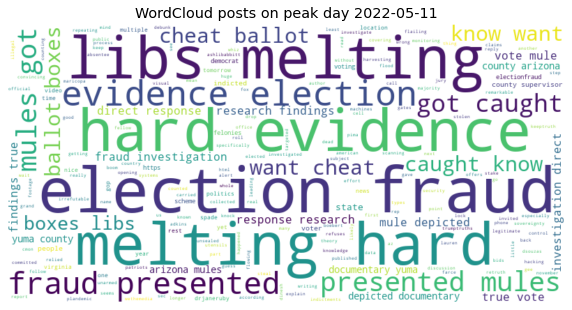

In [51]:
n_peaks = 5
peak_days = election_posts_per_day.sort_values(ascending=False).index[:n_peaks]
get_peaks_wordclouds(peak_days, election_posts)

In [52]:
#for _, row in election_posts[election_posts['day'] == peak_days[4]].sample(n=20).iterrows():
#    print(row['text'])
#    print('\n')

**Analysing shared domains**

In [53]:
def get_link_domain_count(df):
    df['links'] = df['text'].apply(extract_links)
    df = df.explode('links')
    conspiracy_links = df.dropna(subset=['links']).copy()

    conspiracy_links['domain'] = conspiracy_links['links'].apply(extract_domain)

    domain_count = conspiracy_links['domain'].value_counts()
    domain_count.index = domain_count.index.str.replace(r'\.com$', '', regex=True)
    
    return domain_count

In [54]:
qanon_domain_count = get_link_domain_count(qanon_posts)
election_domain_count = get_link_domain_count(election_posts)
climate_domain_count = get_link_domain_count(climate_posts)

In [55]:
df = pd.DataFrame()
df = df.merge(qanon_domain_count, how='outer', left_index=True, right_index=True)
df = df.merge(election_domain_count, how='outer', left_index=True, right_index=True)
df = df.merge(climate_domain_count, how='outer', left_index=True, right_index=True)
df.columns = ['qanon', 'election', 'climate']
df = df.fillna(0)
df['total'] = df.sum(axis=1)
df.sort_values(by='total', ascending=False, inplace=True)
df.head(10)

,qanon,election,climate,total
thegatewaypundit,45.0,310.0,6.0,361.0
rumble,74.0,120.0,7.0,201.0
t.me,158.0,15.0,3.0,176.0
thefederalist,8.0,109.0,1.0,118.0
justthenews,9.0,96.0,5.0,110.0
breitbart,21.0,13.0,15.0,49.0
rsbnetwork,10.0,30.0,0.0,40.0
americanthinker,2.0,34.0,3.0,39.0
theepochtimes,5.0,28.0,4.0,37.0
foxnews,7.0,12.0,14.0,33.0


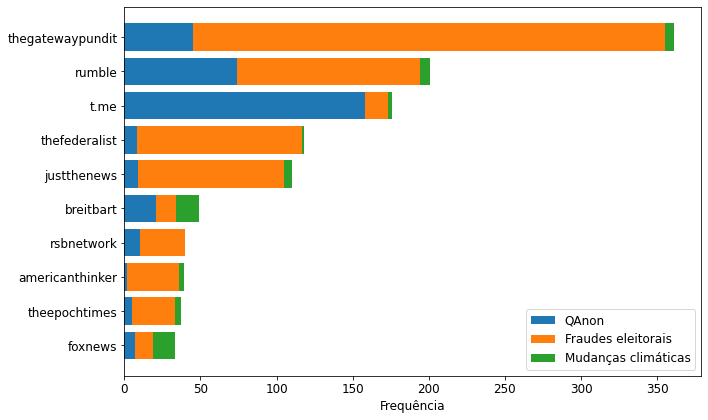

In [57]:
top_domains = df.head(10).sort_values(by='total')
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.barh(top_domains.index, top_domains['qanon'], 
        align='center', 
        label='QAnon')
ax.barh(top_domains.index, top_domains['election'], 
        align='center', 
        left=top_domains['qanon'], 
        label='Fraudes eleitorais')
ax.barh(top_domains.index, top_domains['climate'], 
        align='center', 
        left=top_domains['qanon']+top_domains['election'], 
        label='Mudanças climáticas')

ax.set_xlabel('Frequência')
ax.legend()
plt.tight_layout()
plt.show()

## Conspiracy Network

Creating network graph identifying conspiracy related nodes.

Counting number of conspiracy related posts per user.

In [58]:
qanon_count = qanon_posts.groupby('author').size().reset_index(name='qanon_count')
election_count = election_posts.groupby('author').size().reset_index(name='election_count')
climate_count = climate_posts.groupby('author').size().reset_index(name='climate_count')

consp_users = pd.merge(users, qanon_count, left_on='id', right_on='author', how='left').drop('author', axis=1)
consp_users = pd.merge(consp_users, election_count, left_on='id', right_on='author', how='left').drop('author', axis=1)
consp_users = pd.merge(consp_users, climate_count, left_on='id', right_on='author', how='left').drop('author', axis=1)

columns = ['qanon_count', 'election_count', 'climate_count']
consp_users[columns] = consp_users[columns].fillna(0).astype(int)

consp_users.head()

,id,timestamp,time_scraped,username,follower_count,following_count,profile_url,finished_follower_scrape,finished_following_scrape,finished_truth_scrape,qanon_count,election_count,climate_count
0,22,2022-05-01,2022-09-04 23:14:03,ProjectVeritasAction,455386.0,2.0,https://truthsocial.com/@ProjectVeritasAction,1.0,1.0,1.0,0,0,0
1,23,2022-05-01,2022-09-04 23:32:45,ProjectVeritas,617923.0,15.0,https://truthsocial.com/@ProjectVeritas,1.0,1.0,1.0,0,1,2
2,24,2022-05-01,2022-09-04 23:32:57,JamesOKeefeIII,395827.0,5.0,https://truthsocial.com/@JamesOKeefeIII,1.0,1.0,1.0,0,0,1
3,25,2022-02-01,2022-09-04 23:34:48,JCSullivan,6942.0,221.0,https://truthsocial.com/@JCSullivan,0.0,0.0,0.0,0,0,0
4,26,2022-02-01,2022-09-04 23:48:56,EricTrump,1727967.0,178.0,https://truthsocial.com/@EricTrump,1.0,1.0,0.0,0,0,0


Top 10 most conspiracy related users

In [59]:
consp_users.sort_values(by='qanon_count', ascending=False)[['username', 'qanon_count']].head(10)

,username,qanon_count
7857,MichaelTheGreatPrince,378
10951,MassholePatriot,164
8079,17Qtips45,160
4248,WarriorNurse,103
14326,GenLady,50
21730,DaisyLiberty,47
19960,marknicholson,37
2764,Suzi313,36
7773,Hfj999,35
10909,barbieschu,34


In [60]:
consp_users.sort_values(by='election_count', ascending=False)[['username', 'election_count']].head(10)

,username,election_count
4248,WarriorNurse,162
7949,PatriotAR,70
299,DineshDSouza,65
12454,NavyCMC,64
10755,kefirm,55
4672,imjustjack,47
6525,gtrim,38
8174,Freedom44,34
9196,vlf0715,33
5,realDonaldTrump,33


In [61]:
consp_users.sort_values(by='climate_count', ascending=False)[['username', 'climate_count']].head(10)

,username,climate_count
4844,sassyconservative,41
9297,Sunnyc45,34
12897,TUBA1956,28
6567,kthornton,27
11083,MichaelDC519,18
10948,ILoveAmericaNews,13
8703,USA2A,13
393,catturd2,12
10389,FJHalle,11
432,sdebra,9


In [62]:
conditions = [
    (consp_users['qanon_count'] > 0) & (consp_users['election_count'] == 0) & (consp_users['climate_count'] == 0),
    (consp_users['qanon_count'] == 0) & (consp_users['election_count'] > 0) & (consp_users['climate_count'] == 0),
    (consp_users['qanon_count'] == 0) & (consp_users['election_count'] == 0) & (consp_users['climate_count'] > 0),
    (consp_users['qanon_count'] > 0) & (consp_users['election_count'] > 0) & (consp_users['climate_count'] == 0),
    (consp_users['qanon_count'] > 0) & (consp_users['election_count'] == 0) & (consp_users['climate_count'] > 0),
    (consp_users['qanon_count'] == 0) & (consp_users['election_count'] > 0) & (consp_users['climate_count'] > 0),
    (consp_users['qanon_count'] > 0) & (consp_users['election_count'] > 0) & (consp_users['climate_count'] > 0)
]

categories = ['qanon', 'election', 'climate', 'qanon,election', 'qanon,climate', 'election,climate', 'qanon,election,climate']

consp_users['category'] = np.select(conditions, categories, default='none')
consp_users['conspiracy_count'] = consp_users[['qanon_count', 'election_count', 'climate_count']].sum(axis=1)

consp_users.head()

,id,timestamp,time_scraped,username,follower_count,following_count,profile_url,finished_follower_scrape,finished_following_scrape,finished_truth_scrape,qanon_count,election_count,climate_count,category,conspiracy_count
0,22,2022-05-01,2022-09-04 23:14:03,ProjectVeritasAction,455386.0,2.0,https://truthsocial.com/@ProjectVeritasAction,1.0,1.0,1.0,0,0,0,none,0
1,23,2022-05-01,2022-09-04 23:32:45,ProjectVeritas,617923.0,15.0,https://truthsocial.com/@ProjectVeritas,1.0,1.0,1.0,0,1,2,"election,climate",3
2,24,2022-05-01,2022-09-04 23:32:57,JamesOKeefeIII,395827.0,5.0,https://truthsocial.com/@JamesOKeefeIII,1.0,1.0,1.0,0,0,1,climate,1
3,25,2022-02-01,2022-09-04 23:34:48,JCSullivan,6942.0,221.0,https://truthsocial.com/@JCSullivan,0.0,0.0,0.0,0,0,0,none,0
4,26,2022-02-01,2022-09-04 23:48:56,EricTrump,1727967.0,178.0,https://truthsocial.com/@EricTrump,1.0,1.0,0.0,0,0,0,none,0


In [63]:
columns = ['qanon_count', 'election_count', 'climate_count']
only_consp_users = consp_users.loc[(consp_users[columns] != 0).any(axis=1)]
only_consp_users.head()

,id,timestamp,time_scraped,username,follower_count,following_count,profile_url,finished_follower_scrape,finished_following_scrape,finished_truth_scrape,qanon_count,election_count,climate_count,category,conspiracy_count
1,23,2022-05-01,2022-09-04 23:32:45,ProjectVeritas,617923.0,15.0,https://truthsocial.com/@ProjectVeritas,1.0,1.0,1.0,0,1,2,"election,climate",3
2,24,2022-05-01,2022-09-04 23:32:57,JamesOKeefeIII,395827.0,5.0,https://truthsocial.com/@JamesOKeefeIII,1.0,1.0,1.0,0,0,1,climate,1
5,27,2022-02-01,2022-12-09 02:48:14,realDonaldTrump,4027829.0,3.0,https://truthsocial.com/@realDonaldTrump,1.0,1.0,1.0,0,33,1,"election,climate",34
6,28,2022-02-01,2022-12-10 00:47:19,realamericasvoice,83966.0,70.0,https://truthsocial.com/@realamericasvoice,1.0,1.0,1.0,0,2,0,election,2
7,29,2022-02-01,2022-09-06 17:35:53,mariabartiromo,937567.0,54.0,https://truthsocial.com/@mariabartiromo,1.0,1.0,1.0,0,1,2,"election,climate",3


In [64]:
columns = ['qanon', 'election', 'climate']
only_consp_truths = truths.loc[(truths[columns] == True).any(axis=1)]
only_consp_truths.head()

,id,timestamp,time_scraped,is_retruth,is_reply,author,like_count,retruth_count,reply_count,text,url,truth_retruthed,external_id,links,qanon,election,climate
436,543,2022-08-08 13:52:00,2022-09-15 19:47:17,0,0,103,2330,483,161,TRUMP: “What we do in the next few months…will...,https://truthsocial.com/@seanhannity/posts/108...,-1,108788524200562376,[https://hannity.com/media-room/drain-the-swam...,True,False,False
536,671,2022-07-27 08:01:00,2022-09-15 19:49:37,0,0,103,298,63,149,CBS: Ice Cream Is Endangered Because of Climat...,https://truthsocial.com/@seanhannity/posts/108...,-1,108719195109301948,[https://rumble.com/v1dsbbx-cbs-ice-cream-is-e...,False,False,True
629,787,2022-07-15 09:15:00,2022-09-15 19:51:47,0,0,103,1300,233,125,MANCHIN SPOX: “Senator Manchin believes it’s t...,https://truthsocial.com/@seanhannity/posts/108...,-1,108651541941532913,[https://hannity.com/media-room/still-the-manc...,False,False,True
1039,1304,2022-05-25 08:38:00,2022-09-15 20:01:53,0,0,103,625,281,679,Mayorkas Blames Border Crisis on People Fleein...,https://truthsocial.com/@seanhannity/posts/108...,-1,108362617503944992,[https://rumble.com/v161m2d-sec.-mayorkas-blam...,False,False,True
1440,1770,2022-08-30 07:45:00,2022-09-15 22:40:45,0,0,27,10100,4070,422,This is the man responsible for investigating ...,https://truthsocial.com/@realDonaldTrump/posts...,-1,108911653157117506,[],False,True,False


In [65]:
users_with_posts = truths['author'].unique().tolist()
only_users_with_posts = consp_users[consp_users['id'].isin(users_with_posts)]

G = nx.DiGraph()

# Adding nodes
for _, user in only_users_with_posts.iterrows():
    G.add_node(user['id'], 
               nickname=user['username'], 
               category=user['category'], 
               conspiracy_count=user['conspiracy_count'])

In [66]:
consp_retruths = only_consp_truths[only_consp_truths['is_retruth'] == 1]
for _, truth in consp_retruths.iterrows():
    original_post_id = truth['truth_retruthed']
    res = truths.loc[truths['id'] == original_post_id, 'author']
    # If Truth retruthed is on dataset
    if not res.empty:
        original_author_id = res.item()
        # Add directed edge from repost author to original author
        G.add_edge(truth['author'], original_author_id)

In [67]:
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

nx.write_graphml(G, "parcial_graph.graphml")

Number of nodes: 17307
Number of edges: 2747


In [68]:
# Adding edges
"""
retruths = truths[truths['is_retruth'] == 1]
for _, truth in retruths.iterrows():
    original_post_id = truth['truth_retruthed']
    res = truths.loc[truths['id'] == original_post_id, 'author']
    # If Truth retruthed is on dataset
    if not res.empty:
        original_author_id = res.item()
        # Add directed edge from repost author to original author
        G.add_edge(truth['author'], original_author_id)
"""

"\nretruths = truths[truths['is_retruth'] == 1]\nfor _, truth in retruths.iterrows():\n    original_post_id = truth['truth_retruthed']\n    res = truths.loc[truths['id'] == original_post_id, 'author']\n    # If Truth retruthed is on dataset\n    if not res.empty:\n        original_author_id = res.item()\n        # Add directed edge from repost author to original author\n        G.add_edge(truth['author'], original_author_id)\n"

### Network Homophily

In [69]:
G_homo = G.subgraph(only_consp_users['id'].tolist())

print("Number of nodes:", G_homo.number_of_nodes())
print("Number of edges:", G_homo.number_of_edges())

Number of nodes: 1791
Number of edges: 2747


In [70]:
categories = ['qanon',
              'election',
              'climate',
              'qanon,election',
              'qanon,climate', 
              'election,climate',
              'qanon,election,climate']

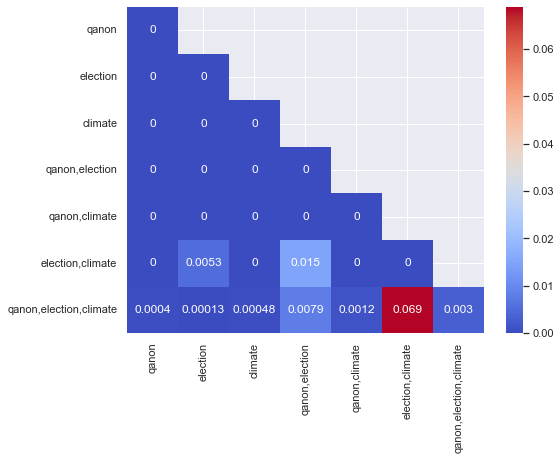

In [87]:
matrix = np.zeros((len(categories), len(categories)))

for i, category1 in enumerate(categories):
    for j, category2 in enumerate(categories):
        if i <= j:
            subgraph = G_homo.subgraph([node for node, data in G_homo.nodes(data=True) 
                                        if data['category'] in {category1, category2}])
            
            metric = nx.average_clustering(subgraph)
            
            # Armazenar na matriz
            matrix[i, j] = metric
            matrix[j, i] = metric

# Plotar o heatmap
mask = np.triu(np.ones_like(matrix, dtype=bool))
np.fill_diagonal(mask, False)
#mask[np.triu_indices_from(mask)] = True

sns.set()
sns.set_style(rc=plt.rcParams)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, 
            annot=True, 
            mask=mask,
            xticklabels=categories, yticklabels=categories, 
            cmap="coolwarm")
plt.show()